In [ ]:
!pip install catboost lightgbm

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Анализ данных


In [13]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [6]:
train_df.head()

,id,has_null,wave,gender,age,age_o,race,race_o,samerace,importance_same_race,importance_same_religion,field,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,0,1,11.0,female,27.0,25.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,4.0,4.0,Genetics,25.00,20.00,30.00,15.00,5.00,5.00,7.0,7.0,8.0,7.0,8.0,7.0,19.0,20.0,19.0,14.0,13.0,15.0,6.0,9.0,7.0,9.0,6.0,7.0,9.0,9.0,8.0,8.0,6.0,9.0,6.0,7.0,9.0,5.0,5.0,6.0,2.0,3.0,9.0,6.0,7.0,7.0,9.0,9.0,5.0,3.0,0.62,6.0,NaN,4.0,7.0,5.0,1.0,1
1,1,1,21.0,female,22.0,24.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,1.0,1.0,Mechanical Engineering,20.00,20.00,20.00,20.00,10.00,10.00,5.0,8.0,8.0,7.0,8.0,2.0,20.0,20.0,10.0,15.0,5.0,30.0,3.0,9.0,9.0,9.0,7.0,7.0,8.0,7.0,8.0,8.0,8.0,7.0,10.0,5.0,6.0,3.0,8.0,6.0,7.0,6.0,3.0,5.0,8.0,10.0,9.0,10.0,6.0,3.0,-0.20,8.0,NaN,6.0,7.0,5.0,0.0,0
2,2,1,4.0,male,22.0,22.0,Asian/Pacific Islander/Asian-American,European/Caucasian-American,0,3.0,2.0,financial math,15.00,20.00,20.00,20.00,15.00,10.00,3.0,5.0,6.0,3.0,NaN,2.0,40.0,8.0,10.0,12.0,10.0,20.0,8.0,8.0,8.0,9.0,9.0,7.0,NaN,6.0,5.0,NaN,NaN,9.0,9.0,7.0,9.0,9.0,9.0,8.0,8.0,9.0,8.0,7.0,9.0,8.0,7.0,8.0,8.0,4.0,-0.21,7.0,14.0,5.0,6.0,3.0,0.0,0
3,3,0,2.0,male,21.0,23.0,European/Caucasian-American,European/Caucasian-American,1,10.0,9.0,Law,20.00,20.00,20.00,15.00,15.00,10.00,2.0,7.0,6.0,4.0,4.0,4.0,15.0,20.0,15.0,30.0,5.0,15.0,5.0,8.0,6.0,8.0,7.0,8.0,7.0,7.0,7.0,6.0,6.0,8.0,5.0,3.0,6.0,3.0,4.0,3.0,3.0,3.0,3.0,7.0,4.0,6.0,3.0,5.0,4.0,2.0,0.06,5.0,1.0,2.0,7.0,3.0,0.0,0
4,4,1,14.0,female,26.0,30.0,Latino/Hispanic American,European/Caucasian-American,0,1.0,3.0,International Security Policy - SIPA,31.58,10.53,15.79,21.05,10.53,10.53,8.0,6.0,7.0,7.0,7.0,6.0,15.0,15.0,15.0,20.0,20.0,15.0,7.0,7.0,8.0,8.0,9.0,6.0,6.0,6.0,6.0,6.0,6.0,9.0,7.0,5.0,6.0,7.0,6.0,4.0,3.0,9.0,4.0,4.0,9.0,9.0,9.0,9.0,9.0,5.0,0.32,5.0,NaN,9.0,7.0,5.0,0.0,0


In [7]:
train_df.describe()

,id,has_null,wave,age,age_o,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,pref_o_intelligence,pref_o_funny,pref_o_ambitious,pref_o_shared_interests,attractive_o,sinsere_o,intelligence_o,funny_o,ambitous_o,shared_interests_o,attractive_important,sincere_important,intellicence_important,funny_important,ambtition_important,shared_interests_important,attractive,sincere,intelligence,funny,ambition,attractive_partner,sincere_partner,intelligence_partner,funny_partner,ambition_partner,shared_interests_partner,sports,tvsports,exercise,dining,museums,art,hiking,gaming,clubbing,reading,tv,theater,movies,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
count,6702.000000,6702.000000,6702.000000,6626.000000,6620.000000,6702.000000,6639.000000,6639.000000,6631.000000,6631.000000,6631.000000,6624.000000,6617.000000,6603.000000,6526.000000,6461.000000,6450.000000,6402.000000,6111.000000,5820.000000,6639.000000,6639.000000,6639.000000,6630.000000,6621.000000,6607.000000,6617.000000,6617.000000,6617.000000,6617.000000,6617.000000,6541.000000,6476.000000,6463.000000,6413.000000,6120.000000,5848.000000,6639.000000,6639.000000,6639.00000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6639.000000,6577.000000,6623.000000,1458.000000,5743.000000,6514.000000,6452.000000,6399.000000,6702.000000
mean,3350.500000,0.874067,11.350045,26.345306,26.305438,0.398090,3.790029,3.639554,22.463742,17.410780,20.273078,17.463219,10.690520,11.848417,6.196889,7.176908,7.377132,6.405576,6.790623,5.496306,22.525632,17.407379,20.314669,17.456383,10.656695,11.819761,7.077528,8.288802,7.690948,8.402750,7.575336,6.189711,7.179200,7.366393,6.391626,6.770915,5.471956,6.451273,4.584124,6.25787,7.782497,6.985239,6.720289,5.745293,3.866697,5.743034,7.682934,5.291008,6.787619,7.917759,6.844555,7.865191,5.640006,4.344480,0.195326,5.535105,5.615912,3.227181,6.142109,5.218227,0.049383,0.163981
std,1934.845084,0.331798,6.028025,3.580997,3.528924,0.489541,2.852751,2.802596,12.522203,6.958779,6.678146,6.008834,6.116786,6.360859,1.958642,1.739666,1.546452,1.948191,1.779882,2.152490,12.647021,7.045097,6.781936,6.036754,6.167333,6.386480,1.390351,1.406556,1.565141,1.081592,1.765615,1.965851,1.737116,1.551094,1.965536,1.792232,2.159590,2.610037,2.793343,2.40801,1.754430,2.044789,2.255039,2.565335,2.603999,2.513405,1.994402,2.520592,2.235480,1.710217,2.151731,1.788549,2.595556,2.714417,0.303984,1.730201,4.795396,2.467702,1.839384,2.134206,0.274017,0.370286
min,0.000000,0.000000,1.000000,18.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-0.830000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1675.250000,1.000000,7.000000,24.000000,24.000000,0.000000,1.000000,1.000000,15.000000,15.000000,17.390000,15.000000,5.000000,9.520000,5.000000,6.000000,6.000000,5.000000,6.000000,4.000000,15.000000,15.000000,17.650000,15.000000,5.000000,8.755000,6.000000,8.000000,7.000000,8.000000,7.000000,5.000000,6.000000,6.000000,5.000000,6.000000,4.000000,5.000000,2.000000,5.00000,7.000000,6.000000,5.000000,4.000000,2.000000,4.000000,7.000000,3.000000,5.000000,7.000000,5.000000,7.000000,4.000000,2.000000,-0.020000,5.000000,2.000000,2.000000,5.000000,4.000000,0.000000,0.000000
50%,3350.500000,1.000000,11.000000,26.000000,26.000000,0.000000,3.000000,3.000000,20.000000,18.180000,20.000000,18.000000,10.000000,10.870000,6.000000,7.000000,7

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6702 entries, 0 to 6701
Data columns (total 66 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             6702 non-null   int64  
 1   has_null                       6702 non-null   int64  
 2   wave                           6702 non-null   float64
 3   gender                         6702 non-null   object 
 4   age                            6626 non-null   float64
 5   age_o                          6620 non-null   float64
 6   race                           6651 non-null   object 
 7   race_o                         6645 non-null   object 
 8   samerace                       6702 non-null   int64  
 9   importance_same_race           6639 non-null   float64
 10  importance_same_religion       6639 non-null   float64
 11  field                          6651 non-null   object 
 12  pref_o_attractive              6631 non-null   f

In [9]:
num_cols = []
for col in train_df.columns:
  if train_df[col].dtype != 'object':
    num_cols.append(col)
num_cols

['id',
 'has_null',
 'wave',
 'age',
 'age_o',
 'samerace',
 'importance_same_race',
 'importance_same_religion',
 'pref_o_attractive',
 'pref_o_sincere',
 'pref_o_intelligence',
 'pref_o_funny',
 'pref_o_ambitious',
 'pref_o_shared_interests',
 'attractive_o',
 'sinsere_o',
 'intelligence_o',
 'funny_o',
 'ambitous_o',
 'shared_interests_o',
 'attractive_important',
 'sincere_important',
 'intellicence_important',
 'funny_important',
 'ambtition_important',
 'shared_interests_important',
 'attractive',
 'sincere',
 'intelligence',
 'funny',
 'ambition',
 'attractive_partner',
 'sincere_partner',
 'intelligence_partner',
 'funny_partner',
 'ambition_partner',
 'shared_interests_partner',
 'sports',
 'tvsports',
 'exercise',
 'dining',
 'museums',
 'art',
 'hiking',
 'gaming',
 'clubbing',
 'reading',
 'tv',
 'theater',
 'movies',
 'concerts',
 'music',
 'shopping',
 'yoga',
 'interests_correlate',
 'expected_happy_with_sd_people',
 'expected_num_interested_in_me',
 'expected_num_matche

Посмотрим распределение всех признаков

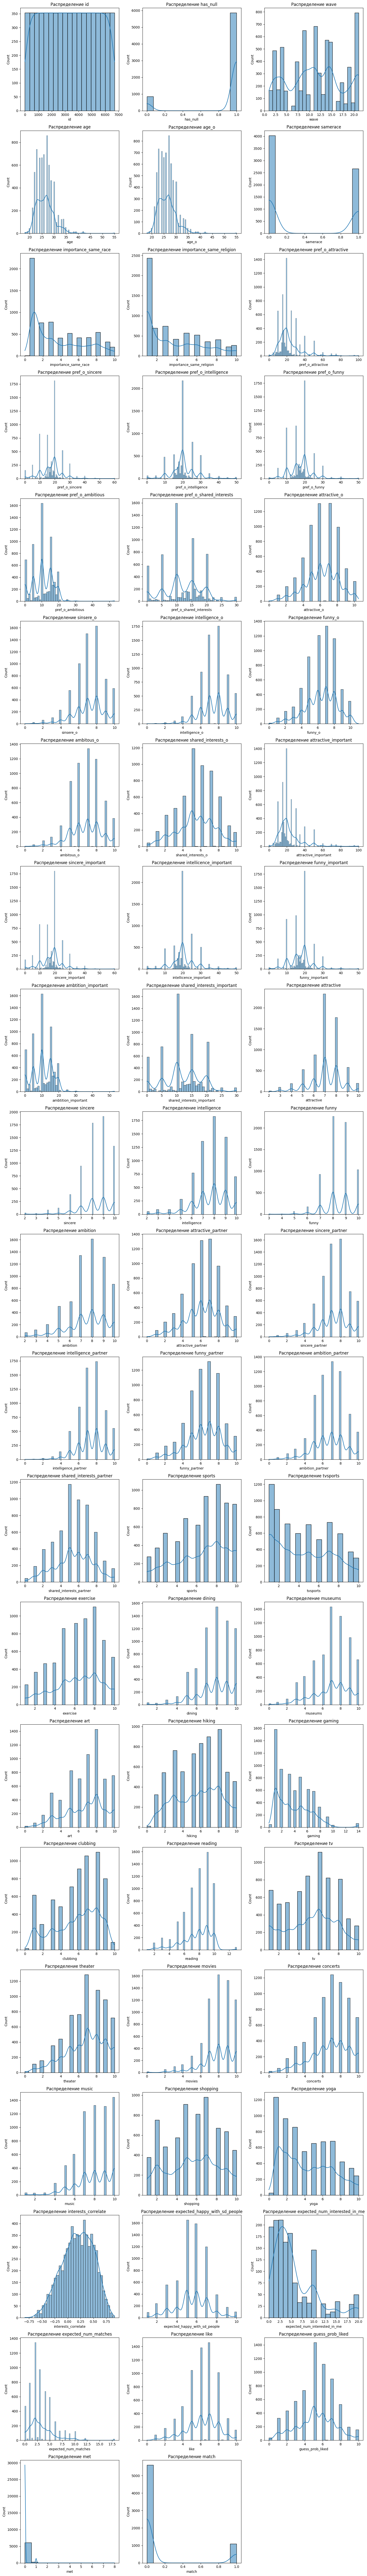

In [10]:
def plot_feature_distribution(df):
    num_features = len(df.columns)

    n_cols = 3
    n_rows = (num_features + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

    for i, column in enumerate(df.columns):
        row = i // n_cols
        col = i % n_cols
        sns.histplot(df[column], ax=axes[row, col], kde=True)
        axes[row, col].set_title(f'Распределение {column}')

    for j in range(i + 1, n_rows * n_cols):
        fig.delaxes(axes[j // n_cols, j % n_cols])

    plt.tight_layout()
    plt.show()

plot_feature_distribution(train_df.loc[:, num_cols])


Отсюда видно, что большинство фичей - категориальные, что поможет нам точнее заполнить пропуски

Закодируем колонки, которые предоставлены в строчном формате для дальнейшей работы

In [14]:
cat_cols = []
for col in train_df.columns:
  if train_df[col].dtype == 'object':
    cat_cols.append(col)

label_encoders = {}
for feature in cat_cols:
    le = LabelEncoder()
    train_df[feature] = le.fit_transform(train_df[feature].astype(str))
    test_df[feature] = le.fit_transform(test_df[feature].astype(str))
    label_encoders[feature] = le

Так же мы заметили, что в датасете очень много пропусков

In [19]:
train_df.isna().sum().sum()

14633

In [24]:
missing_values = train_df.isna().sum()
sorted_missing_values = missing_values.sort_values(ascending=False)

sorted_missing_values

expected_num_interested_in_me    5244
expected_num_matches              959
shared_interests_o                882
shared_interests_partner          854
ambitous_o                        591
                                 ... 
race_o                              0
race                                0
gender                              0
wave                                0
match                               0
Length: 66, dtype: int64

Видим, что в expected_num_interested_in_me большинство пропуски. Так же много пропусков в expected_num_matches, shared_interests_o, shared_interests_partner - дропнем их

In [26]:
cols_to_drop = ['expected_num_interested_in_me', 'expected_num_matches', 'shared_interests_partner']
train_df = train_df.drop(columns = cols_to_drop)
test_df = test_df.drop(columns = cols_to_drop)

Остальные признаки будем заменять так: если признак "насколько важно" и интерес, то будем заполнять нулями, потому что пользователь, скорее всего, это намеренно не указал. Другие признеаки будем заполнять с помощью KNNImputer, предположив, что люди в целом разделимы на какие-то группы и у схожих людей - схожие интересы

In [29]:
importance_interest_features = [
    'importance_same_race', 'importance_same_religion',
    'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests',
    'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important'
]

train_df[importance_interest_features] = train_df[importance_interest_features].fillna(0)

other_features = [
    'gender', 'age', 'age_o', 'race', 'race_o', 'samerace', 'field',
    'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o',
    'attractive', 'sincere', 'intelligence', 'funny', 'ambition',
    'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner',
    'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
    'movies', 'concerts', 'music', 'shopping', 'yoga',
    'interests_correlate', 'expected_happy_with_sd_people',
    'like', 'guess_prob_liked', 'met'
]

imputer_df = train_df[other_features]

imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(imputer_df)

imputed_df = pd.DataFrame(imputed_data, columns=other_features)

train_df[other_features] = imputed_df

0


Попробуем посмотреть, разделимы ли данные на кластеры пользователей

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


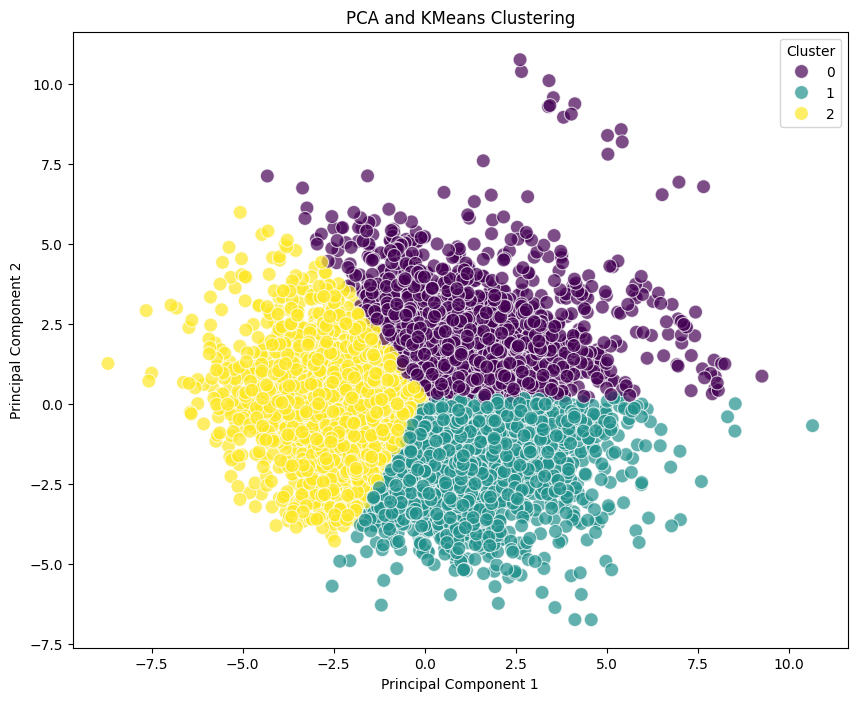

In [32]:
features = train_df.columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(train_df[features])

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(pca_result)
labels = kmeans.labels_

pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = labels

plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', s=100, alpha=0.7)
plt.title('PCA and KMeans Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()


Видим, что не получается выделить кластеры и как-то использовать эту информацию

Есть гипотеза, что внешность люди схожие по attractivness rate встречаются чаще, проверим это статистически

Для проверки гипотезы можно использовать статистический тест на проверку зависимости между двумя категориальными переменными. В данном случае мы будем использовать коэффициент V Крамера, который является мерой силы ассоциации между двумя категориальными переменными.

In [72]:
from scipy.stats import chi2_contingency
# Создание категорий
bins = [0, 5, 8, 10]
labels = ['0-5', '6-8', '9-10']

# Применение категорий к данным
train_df['attractive_partner_cat'] = pd.cut(train_df['attractive_partner'], bins=bins, labels=labels)
train_df['attractive_o_cat'] = pd.cut(train_df['attractive_o'], bins=bins, labels=labels)

# Создание кросс-таблицы
cross_table = pd.crosstab(train_df['attractive_partner_cat'], train_df['attractive_o_cat'])

# Выполнение теста Хи-квадрат для получения p-value
chi2, p, _, _ = chi2_contingency(cross_table)

# Вычисление коэффициента V Крамера
n = cross_table.sum().sum()
phi2 = chi2 / n
r, k = cross_table.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
r_corr = r - ((r-1)**2)/(n-1)
k_corr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2corr / min((k_corr-1), (r_corr-1)))
print(f"Cramér's V coefficient: {cramers_v}")
print(f"P-value: {p}")


Cramér's V coefficient: 0.038522506312433896
P-value: 8.59370533914671e-05


Можно сделать, что это предположение не является правдой в силу маленьких значений


# Подбор модели

Для начала дропнем индексы и has_null, так как они не несут в себе значимой информации

In [34]:
train_df = train_df.drop(columns = ['id', 'has_null'])
test_df = test_df.drop(columns = ['id', 'has_null'])

In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier

X = train_df.drop(columns = ['match'])
y = train_df['match']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Линейная регрессия
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_log_reg)}")
print(f"Precision: {precision_score(y_test, y_pred_log_reg)}")
print(f"Recall: {recall_score(y_test, y_pred_log_reg)}")
print(f"F1 Score: {f1_score(y_test, y_pred_log_reg)}")

# CatBoostClassifier
catboost = CatBoostClassifier(verbose=100)
catboost.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)
y_pred_catboost = catboost.predict(X_test)
print("\nCatBoostClassifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_catboost)}")
print(f"Precision: {precision_score(y_test, y_pred_catboost)}")
print(f"Recall: {recall_score(y_test, y_pred_catboost)}")
print(f"F1 Score: {f1_score(y_test, y_pred_catboost)}")

# LGBMClassifier
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, eval_set=(X_test, y_test))
y_pred_lgbm = lgbm.predict(X_test)
print("\nLGBMClassifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lgbm)}")
print(f"Precision: {precision_score(y_test, y_pred_lgbm)}")
print(f"Recall: {recall_score(y_test, y_pred_lgbm)}")
print(f"F1 Score: {f1_score(y_test, y_pred_lgbm)}")

# MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print("\nMLPClassifier Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_mlp)}")
print(f"Precision: {precision_score(y_test, y_pred_mlp)}")
print(f"Recall: {recall_score(y_test, y_pred_mlp)}")
print(f"F1 Score: {f1_score(y_test, y_pred_mlp)}")

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Metrics:
Accuracy: 0.8612975391498882
Precision: 0.5980392156862745
Recall: 0.2961165048543689
F1 Score: 0.39610389610389607
Learning rate set to 0.047977
0:	learn: 0.6541591	test: 0.6531961	best: 0.6531961 (0)	total: 13ms	remaining: 13s
100:	learn: 0.2733801	test: 0.3126733	best: 0.3126733 (100)	total: 604ms	remaining: 5.38s
200:	learn: 0.2214152	test: 0.3070100	best: 0.3067864 (197)	total: 1.19s	remaining: 4.71s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.3067864374
bestIteration = 197

Shrink model to first 198 iterations.

CatBoostClassifier Metrics:
Accuracy: 0.866517524235645
Precision: 0.6363636363636364
Recall: 0.3058252427184466
F1 Score: 0.4131147540983606
[LightGBM] [Info] Number of positive: 893, number of negative: 4468
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

Видим, что все бустинги показывают лучшее и соизмеримое качество, в качестве финального сабмита будем использовать их

Посмотрим, какие фичи наиболее сильно влияют на предсказание

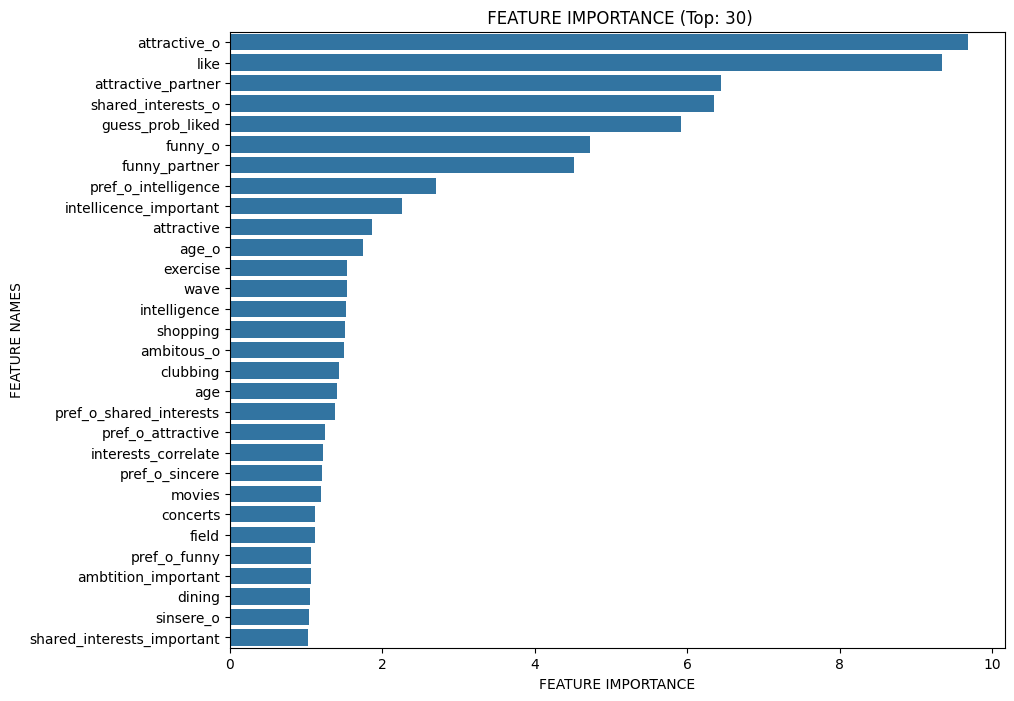

In [60]:
def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=[]):
    """Функция вывода feature importance
        :importance - массив важности фичей, полученный от модели
        :names - массив названий фичей
        :model_name - название модели
        :top_n - кол-во выводимых фичей
        :skip_columns: какие фичи пропустить, такое может понадобиться чтобы временно убрать
                        из отображаемых горячие фичи, и изучить менее сильные
        :return - fi_df - feature importance датафрейм
    """
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df


dfi = plot_feature_importance(catboost.get_feature_importance(), X.columns, top_n=30)

Видим, что внешность играет наиболее важную роль в принятии решений

In [46]:
from sklearn.ensemble import VotingClassifier

catboost_models = [(f'cb_{i}', CatBoostClassifier(random_seed=42 + i, silent=True)) for i in range(3)]
lgbm_model = [(f'lgb_0', LGBMClassifier(is_unbalance=True, random_state=42))]

model = VotingClassifier(estimators=catboost_models + lgbm_model, voting='hard')
model.fit(X, y)

[LightGBM] [Info] Number of positive: 1099, number of negative: 5603
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2363
[LightGBM] [Info] Number of data points in the train set: 6702, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163981 -> initscore=-1.628901
[LightGBM] [Info] Start training from score -1.628901


VotingClassifier(estimators=[('cb_0',
                              <catboost.core.CatBoostClassifier object at 0x7f6627068550>),
                             ('cb_1',
                              <catboost.core.CatBoostClassifier object at 0x7f662706bdf0>),
                             ('cb_2',
                              <catboost.core.CatBoostClassifier object at 0x7f662706a380>),
                             ('lgb_0',
                              LGBMClassifier(is_unbalance=True,
                                             random_state=42))])

In [50]:
sample_submission['target'] = model.predict(test_df)



In [53]:
sample_submission.to_csv('submission_den.csv', index = False)

Как итог получили устойчивую модель, которая на лб отработала примерно так же, как и на валидации, что позволило занять 3 место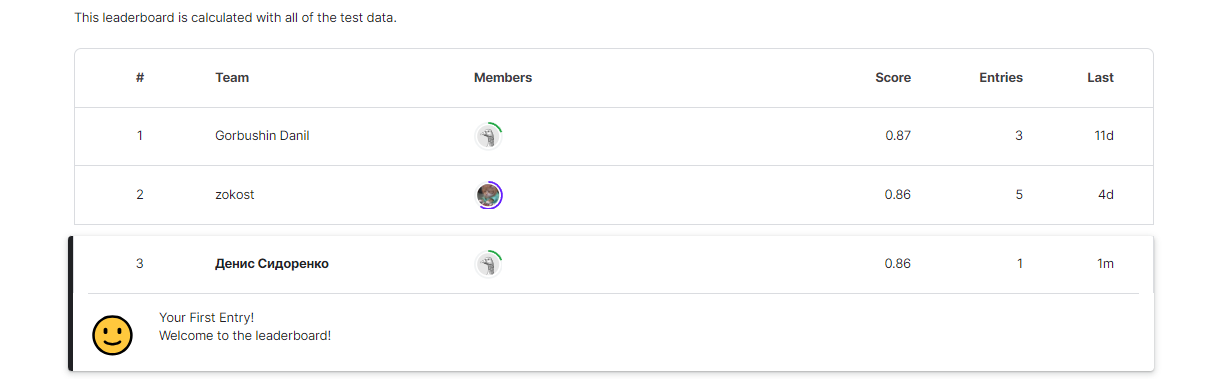